In [3]:
%reset -f

import sys

import numpy as np
import pandas as pd
import time
sys.path.insert(
    1, '/Users/haas/Documents/Masters/ml_lattice_qcd'
)

import random

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from activation_functions import *
from FFNN import FFNN

# import accuracy score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
)
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from utils import *

cmt = 1 / 2.54
sns.set_palette('pastel')

## Training Regression

2023-03-03 21:37:21.661262: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 0s 4ms/step
RMSE1:  0.05619445745883751
rmse over average of ytest =  0.046307039805988694
CPU times: user 34min 37s, sys: 3min 7s, total: 37min 45s
Wall time: 9min 2s


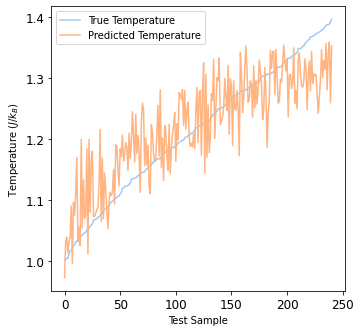

In [6]:
%%time

# lenet inspired model
# now we replicate LeNet-5
Xtrain, Xtest, ytrain, ytest = Potts.load_data(split=True, scale=True)
# first reshape Xtrain and Xtest to 4D arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)
# create model
model1 = Sequential()
# add model layers
eta = 1e-4
l2 = 0.01
l2_reg = regularizers.l2(l2)
epochs = 1000
model1.add(
    Conv2D(
        6,
        kernel_size=5,
        activation='leaky_relu',
        input_shape=(50, 50, 1),
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
# model.add(AveragePooling2D(pool_size=(4, 4)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(
    Conv2D(
        16,
        kernel_size=5,
        activation='leaky_relu',
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
model1.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(AveragePooling2D(pool_size=(4, 4)))
model1.add(Flatten())
model1.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
model1.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
model1.add(Dense(1, activation='linear'))
# compile model using accuracy to measure model performance
sgd = SGD(learning_rate=eta, decay=5e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=eta, beta_1=0.9, beta_2=0.999, amsgrad=False)

model1.compile(optimizer=adam, loss='mse', metrics='mse')
# train the model
history1 = model1.fit(
    Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=epochs, verbose=0
)   #### change this
#
# evaluate the model
pred1 = model1.predict(Xtest)
order = np.argsort(ytest.ravel())
ytest = ytest[order]
pred1 = pred1[order]

# plot predictions
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(ytest, label='True Temperature')
plt.plot(pred1, label='Predicted Temperature')
plt.legend() 
plt.xlabel('Test Sample')
plt.ylabel('Temperature $(J/k_B)$')
# change ticks font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

info = (
    f'_l2reg{str(l2).replace(".", "")}'
    + '_eta'
    + str(eta).replace('.', '')
    + f'_epoch{str(epochs)}'
)
plt.tight_layout()
plt.savefig('../figs/TF_CNN' + info + '.pdf')


print('RMSE1: ', mean_squared_error(ytest, pred1, squared=False))
rmse1 = np.sqrt(mean_squared_error(pred1, ytest.ravel())) / np.mean(ytest)
print('rmse over average of ytest = ', rmse1)


Text(0, 0.5, 'Loss')

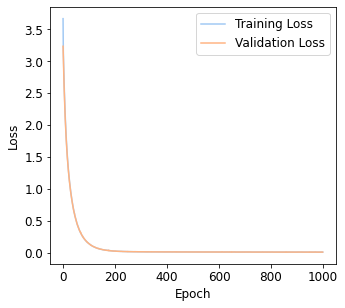

In [17]:
# plot history
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')




### Classification

Epoch 1/400
31/31 [==============================] - 1s 17ms/step - loss: 4.0709 - accuracy: 0.5073 - val_loss: 4.0529 - val_accuracy: 0.4647
Epoch 2/400
31/31 [==============================] - 0s 14ms/step - loss: 4.0173 - accuracy: 0.5457 - val_loss: 4.0251 - val_accuracy: 0.4440
Epoch 3/400
31/31 [==============================] - 0s 15ms/step - loss: 3.9689 - accuracy: 0.5728 - val_loss: 3.9775 - val_accuracy: 0.4481
Epoch 4/400
31/31 [==============================] - 0s 14ms/step - loss: 3.9213 - accuracy: 0.5925 - val_loss: 3.9339 - val_accuracy: 0.4772
Epoch 5/400
31/31 [==============================] - 0s 13ms/step - loss: 3.8784 - accuracy: 0.6123 - val_loss: 3.8829 - val_accuracy: 0.4979
Epoch 6/400
31/31 [==============================] - 0s 14ms/step - loss: 3.8298 - accuracy: 0.6590 - val_loss: 3.8386 - val_accuracy: 0.5602
Epoch 7/400
31/31 [==============================] - 0s 14ms/step - loss: 3.7830 - accuracy: 0.6788 - val_loss: 3.8107 - val_accuracy: 0.5104
Epoch 

Text([1.185], [0.50244397], '[1.185]')

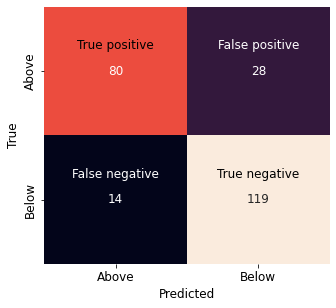

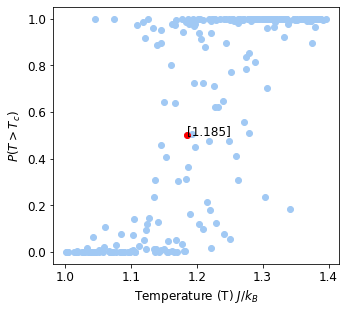

In [8]:
# classification prediction of the Ising model
Xtrain, Xtest, ytrain, ytest = Potts.load_data(scale=True, split=True)

y_test_copy = ytest.copy()

# the potts model critical temperature for q = 5 is 1.20097
true_tc = 1.20097
ytrain[ytrain < true_tc] = 0
ytrain[ytrain >= true_tc] = 1
ytest[ytest < true_tc] = 0
ytest[ytest >= true_tc] = 1

# shuffle y_copy in the exact same way as Xtrain and Xtest

# use the convolutional neural network to classify the data into two classes
# first reshape Xtrain and Xtest to 4D arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)

# create model
model = Sequential()
# add model layers
l2_reg = regularizers.l2(0.01)
model.add(
    Conv2D(
        6,
        kernel_size=5,
        activation='leaky_relu',
        input_shape=(50, 50, 1),
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
# model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(
    Conv2D(
        16,
        kernel_size=5,
        activation='leaky_relu',
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
model.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
model.add(Dense(1, activation='sigmoid'))

# compile model using accuracy to measure model performance
sgd = SGD(learning_rate=0.001, decay=5e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=400)

# evaluate the model
pred = model.predict(Xtest)
soft_pred = pred
hard_pred = np.round(pred)
acc = accuracy_score(ytest, hard_pred)
print('accuracy with CNN = ', acc)
# accuracy with CNN =  0.9920948616600791

# plot confusion matrix with seaborn
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
cm = confusion_matrix(ytest, hard_pred)
sns.heatmap(cm, annot=True, fmt='d')
# remove colorbar
plt.gca().collections[0].colorbar.remove()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# label as true positive, true negative, false positive, false negative
plt.text(
    0.5,
    0.3,
    'True positive',
    ha='center',
    va='center',
    color='black',
    fontsize=12,
)
plt.text(
    1.5,
    0.3,
    'False positive',
    ha='center',
    va='center',
    color='white',
    fontsize=12,
)
plt.text(
    0.5,
    1.3,
    'False negative',
    ha='center',
    va='center',
    color='white',
    fontsize=12,
)
plt.text(
    1.5,
    1.3,
    'True negative',
    ha='center',
    va='center',
    color='black',
    fontsize=12,
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['Above', 'Below'])
plt.yticks([0.5, 1.5], ['Above', 'Below'])


plt.savefig('../figs/TF_CNN_confusion_matrix.pdf')

################################################################
# plot the probabilities as function of temperature
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(y_test_copy, soft_pred, 'o')
plt.xlabel('Temperature (T) $J/k_B$')
plt.ylabel('$P(T > T_c)$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# highlight the point where the probability is closest to 0.5
plt.plot(
    y_test_copy[np.argmin(np.abs(soft_pred - 0.5))],
    soft_pred[np.argmin(np.abs(soft_pred - 0.5))],
    'ro',
)
# print its temperature in the plot figure

plt.text(
    y_test_copy[np.argmin(np.abs(soft_pred - 0.5))],
    soft_pred[np.argmin(np.abs(soft_pred - 0.5))],
    str(y_test_copy[np.argmin(np.abs(soft_pred - 0.5))]),
)